In [147]:
# !pip install matplotlib
import matplotlib.pyplot as plt
import numpy as np
import diode
import dionysus as d
import json
import json
from numpy.random import choice
import csv
from datetime import date, timedelta
import datetime as dt
import matplotlib.dates as mdates
from scipy.ndimage.filters import uniform_filter1d


In [133]:
def sample_counties(date, x, weighted):
    with open('/Users/herbertwang/Duke 2024/Math 412/TDA-COVID-NC/Cases_By_County.json') as fp:
        json_data = json.load(fp)

        if not json_data.get(date) is None:
            countiesData = json_data[date]
        else:
            return None
        cases = []
        counties = []

        
        for key,values in countiesData.items():
            counties.append(key)
            if not weighted:
                cases.append(values[0])
            else:
                cases.append(values[2])
                #print(values[2])

        total = sum(cases)
        # print(total)
        for i in range(len(cases)):
            #print(cases[i])
            #print(total)
            cases[i] = cases[i] / total
            #print(cases[i])
    

        # print(cases)
        # for c in counties:
        #     cases.append(counties[c])
        list_of_counties = choice(counties, x, p= cases,replace=False)

        data = []
        with open("/Users/herbertwang/Duke 2024/Math 412/TDA-COVID-NC/County_Location.csv", encoding='utf-8-sig') as csvf:
            csvReader= csv.DictReader(csvf)
            for rows in csvReader:
                if rows['County'] in list_of_counties:
                    # print (rows)
                    data.append([float(rows['X']), float(rows['Y'])])

        data = np.asarray(np.stack(data))

        return data

In [69]:
def calculate_total_homology(points):
    simplices = diode.fill_alpha_shapes(points)
    f = d.Filtration(simplices)
    m = d.homology_persistence(f)
    # for i,c in enumerate(m):
    #     print(i, c)

    dgms = d.init_diagrams(m, f)
    # print(dgms)
    zero_total_homology = 0
    first_total_homology = 0
    for i, dgm in enumerate(dgms):
        for pt in dgm:
            if i==0 and not pt.death == float("inf"):
                zero_total_homology+= ((pt.birth-pt.death)**2)
            if i==1:
                first_total_homology+= ((pt.birth-pt.death)**2)
            # print(i, pt.birth, pt.death)
    # print(zero_total_homology)
    # print(first_total_homology)
    
    return zero_total_homology, first_total_homology

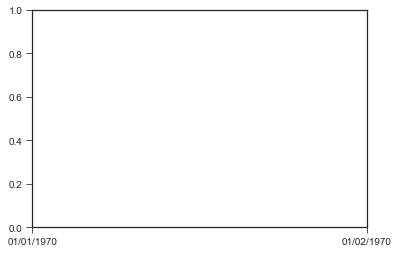

In [184]:
sdate = date(2021, 5, 20)   # start date
# sdate = date(2021, 10, 7)   # start date (test)
edate = date(2021, 11, 7)   # end date

delta = edate - sdate       # as timedelta
date_array_unformatted = []
zero_array = []
first_array = []
total_cases_array = []
for i in range(delta.days + 1):
    day = sdate + timedelta(days=i)
    day = day.strftime("%-m/%-d/%Y")
    total_county_sample = 50
    
    counties = sample_counties(day, total_county_sample, True)
    if not counties is None:
        date_array_unformatted.append(day)
        with open("/Users/herbertwang/Duke 2024/Math 412/TDA-COVID-NC/TABLE_DAILY_CASE&DEATHS_METRICS.csv", encoding='utf-16') as csvf:
            csvReader= csv.DictReader(csvf)
            for rows in csvReader:
                
                if dt.datetime.strptime(rows['Date'], '%m/%d/%y').strftime("%-m/%-d/%Y") == day:
                    total_cases_array.append(float(rows['Cases']))
    else:
        continue
    
    # print(counties)
    zero_total = 0
    first_total = 0
    total_trials = 30
    for j in range(total_trials):
        counties = sample_counties(day, total_county_sample, True)
        zero, first = calculate_total_homology(counties)
        zero_total+=zero
        first_total+=first
    zero_array.append(zero_total/total_trials)
    first_array.append(first_total/total_trials)
        
date_array = [dt.datetime.strptime(d,'%m/%d/%Y').date() for d in date_array_unformatted]
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))

In [185]:
N = len(zero_array)
zero_array_filtered = uniform_filter1d(zero_array, size=10)
first_array_filtered = uniform_filter1d(first_array, size=10)

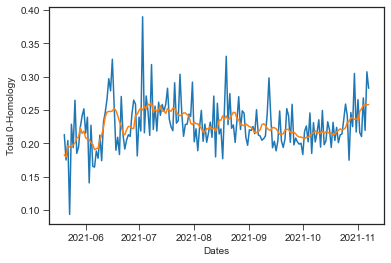

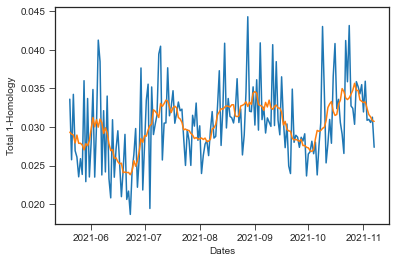

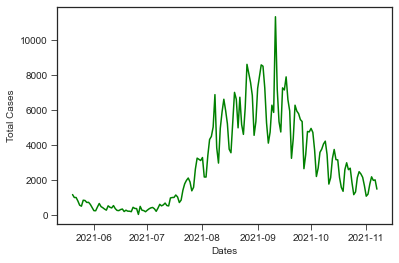

In [186]:
plt.style.use('seaborn-ticks')


plt.plot(date_array,zero_array)
plt.plot(date_array,zero_array_filtered)
plt.ylabel("Total 0-Homology")
plt.xlabel("Dates")
plt.show()

plt.plot(date_array,first_array)
plt.plot(date_array,first_array_filtered)
plt.ylabel("Total 1-Homology")
plt.xlabel("Dates")
plt.show()

plt.plot(date_array,total_cases_array, color = "green")
plt.ylabel("Total Cases")
plt.xlabel("Dates")
plt.show()